***
# K-Means, K-Means++ - clustering algorithms
***

In [19]:
import numpy as np
import matplotlib.pylab as plt

### Создадим функцию для генерации выборок:

function name - generate_dataset(...)

Основное требование от функции: она должна уметь генерировать заданное количество псевдослучайных чисел в указанном ограниченном множестве, которое лежит в $\mathbb{R}^n$ в ***трёх*** режимах: 
1. Просто генерация заданного количества чисел на множестве 
2. Генерация заданного количества чисел в виде кластеров, с заданными центрами для них
3. То же самое что и 2. только центры кластеров тоже генерируются

Для реализации ***первого*** режима я воспользовался функцией numpy: `np.random.rand`, т.е. сгенерировал числа с равномерным распределением по заданному множеству, в принципе, в этой задаче всё тривиально

Для реализации ***второго*** режима мне нужно было понять как сгенирировать точки вокруг центров каждого из кластеров, для этого нужно было решить несколько основных задач:
* Сколько чисел отвести под каждый кластер
* На каком расстоянии от центра кластера поставить точки (расстояние будет зависеть от числа кластеров и размеров множества)

***1)*** (Сколько чисел отвести под каждый кластер) - Для того чтобы не было "перекосов": когда один кластер много больше другого, я генерировал числа из равномерного распределения от $0$ до n_samples$//$n_clusters с округлением, и добиванил остаток равномерно по всем кластерам

***2)*** (На каком расстоянии от центра кластера поставить точки) - Если представить, что наше множество - квадрат, и на нём равномерно разбросаны кластеры (пусть их $N$ штук)(а именно так происходит генерация центров кластеров в 3-м режиме) то можно заметить, что в среднем, на одну сторону квадрата приходится $\sqrt{N}$ кластеров, и представим, что кластер - это круг. Тогда для того, чтобы кластеры были $\approx$ равноудалены, достаточно, чтобы радиус каждого такого круга был равен: 

## $\frac{\alpha}{2*\sqrt{N}}$
где $\alpha$ - сторона квадрата(исходное множество)

Найден радиус кластера, а значит остаётся только использовать нужное распределение для установки точки внутрь этого круга. Возьмём для этого нормальное распределение с $E\xi =$ центр кластера и $\sigma = R/3$ (правило 3-х сигм), где $R =$ радиус круга. Благодаря правилу 3-х сигм примерно $97.7$ процентов точек будет попадать внутрь круга

На самом деле можно было взять и правило 2-х сигм, но после тестирований функции, я пришёл к выводу, что лучше использовать правило 3-х сигм, так как даёт более сгруппированный вид кластерам 

Для реализации ***третьего*** режима необходимо только понять как генерировать центры кластеров, так как в остальном функционал аналогичен 2-му режиму

Центры можно генерировать с равномерным распределением по множеству с помощью функции `np.random.rand`

Функция довольно похожа по своему функционалу на функцию `make_blobs` из `sklearn.datasets`, но весомое различие функций заключается в используемых распределениях: в `make_blobs` используется изотропное гауссовское распределение, в то время как функция `generate_datasets` явно использует только равномерное и нормальное распределение

Функция `generate_datasets` также содержит дополнительные параметры для удобства, и подробную документацию 

In [20]:
# helper functions
def _is_indexable(arg):
    return (not hasattr(arg, "strip") and
            hasattr(arg, "__getitem__"))

def _shuffle_data(x):
    indexes = np.arange(len(x[0]))
    np.random.shuffle(indexes)
    if (len(x) == 1):
        # x[0] is going to be ndarray
        return (x[0][indexes],)
    elif(len(x) >= 2):
        # x[0] and x[1] are going to be ndarray
        return (x[0][indexes], x[1][indexes]) + x[2:]

#returns (ndarray,)
def _rand_generation(n_samples, dims, bounds):
    result = np.random.rand(n_samples, dims)
    result = result * (bounds[1] - bounds[0]) + bounds[0]
    return (result,)

#returns ndarray
def _centers_generation(n_centers, dims, bounds):
    result = np.random.rand(n_centers, dims)
    result = result * (bounds[1] - bounds[0]) + bounds[0]
    return result

#return ndarray
def _distrib_n_samples_gen(n_samples, n_centers):
    n_samples = np.int64(n_samples)
    n_centers = np.int64(n_centers)
    
    middle_n = n_samples // n_centers
    result = np.int64(np.rint(np.random.rand(n_centers) * middle_n))
    n_distributed = result.sum()
    new_middle_n = (n_samples - n_distributed)//n_centers
    result += new_middle_n
    remaining = n_samples - n_distributed - new_middle_n * n_centers
    if remaining != 0:
        vec_add = np.zeros(n_centers, dtype=np.int64)
        vec_add[:remaining] = np.ones(remaining, dtype=np.int64)
        np.random.shuffle(vec_add)
        result += vec_add
    return result

#returns (ndarray, ndarray, ndarray)
def _blobs_generation(n_samples, dims, centers, bounds, return_centers):
    sigma_rule = 3
    if isinstance(centers, int):
        centers = _centers_generation(centers, dims, bounds)
    
    distribute_n = _distrib_n_samples_gen(n_samples, len(centers))
    
    flag_result = flag_labels = None
    result = labels = None
    
    #parameters for normal distribution init
    scale = (bounds[1] - bounds[0])/((sigma_rule**2)*(len(centers)**(1/2)))
    
    for i, one_center in enumerate(centers):
        #parameters for normal distribution init
        loc1 = one_center[0]
        loc2 = one_center[1]
        
        x_coordinate = np.random.normal(loc=loc1, scale=scale, size=(distribute_n[i], 1))
        y_coordinate = np.random.normal(loc=loc2, scale=scale, size=(distribute_n[i], 1))
        x_y_coordinate = np.append(x_coordinate, y_coordinate, axis = 1)
        if flag_result == None:
            flag_result = 1
            result = x_y_coordinate
        else:
            result = np.append(result, x_y_coordinate, axis=0)
        
        current_label = np.ones(distribute_n[i]) * (i + 1)
        if flag_labels == None:
            flag_labels = 1
            labels = current_label
        else:
            labels = np.append(labels, current_label)
    
    if return_centers:
        return result, labels, centers
    else:
        return result, labels


def generate_dataset(n_samples, dims=2, centers=None, shuffle=True,
                     bounds=(-10.0, 10.0), return_centers=False, random_state=None):
    """
    
    generate_dataset - custom function that generates "n_samples" random points in given bounds with some settings
    function is similar to make_blobs function from sklearn in functionality
    
    Function's parameters
    --------------------
    n_samples : int 
        function generate "n_samples" vectors
    dims : int, default=2
        set dimension of vectors to "dims"
    centers : None or int or ndarray of shape(n_samples(or preferably less, but can be more), dims)
        if None, funtion generate random samples in given "bounds" (descriprion of "bounds" below)
        
        if int is given, function will generate samples in "centers" blobs (like a make_blobs from sklearn)
        with using normal distribution, position of centers of blobs are generated at random
        
        if ndarray is given, it detects as centers of blobs
    shuffle: bool, default=True
        permute samples
    bounds : indexable object of float (min, max), default=(-10.0, 10.0)
        if int is given to the "centers", "bounds" is generation area of centers of blobs 
        (so its needed when we use random centers)
    random_state: int, default=None
        seed of numpy's pseudo number generation
        if None - seed isn't set
    return_centers : bool, default=False
        return coordinates of centers of blobs
    
    Return value
    ------------
    Samples : ndarray of shape(n_samples, dims)
        generated samples
    labels : ndarray of shape(n_samples)
        markers for each sample that shows which blob sample belongs to
        doesn't return if "centers" is None
    coord_centers : ndarray of shape(centers, dims)
        The centers of each cluster. Only returned if "return_centers"=True and centers!=None
        
    """
    bounds_length = 2
    
    if isinstance(random_state, int):
        np.random.seed(random_state)
    
    if not isinstance(n_samples, int):
        raise ValueError("'n_samples' must be int")
    
    if not isinstance(dims, int):
        raise ValueError("'dims' must be int")
    
    if (not isinstance(centers, np.ndarray) and (not isinstance(centers, int)) and (centers != None)):
        raise ValueError("'centers' must be None or int or ndarray")
    
    if isinstance(centers, np.ndarray):
        if centers.shape[1] != dims:
            raise ValueError("'centers' must be ndarray of shape(..., dims)")
    
    if _is_indexable(bounds):
        if len(bounds) != bounds_length:
            raise ValueError("'bounds' must have length==2")
        try:
            float(bounds[0])
            float(bounds[1])
        except ValueError:
            raise ValueError("'bounds' must be indexable object with length 2 of floats")
        if bounds[1] <= bounds[0]:
            raise ValueError("'bounds' must be with first argument larger than second argument")
    else:
        raise ValueError("'bounds' must be indexable")
    
    if isinstance(centers, np.ndarray) or isinstance(centers, int):
        result = _blobs_generation(n_samples, dims, centers, bounds, return_centers)
    else:
        result = _rand_generation(n_samples, dims, bounds)
    if shuffle:
        result = _shuffle_data(result)
    return result


генерация одного кластера

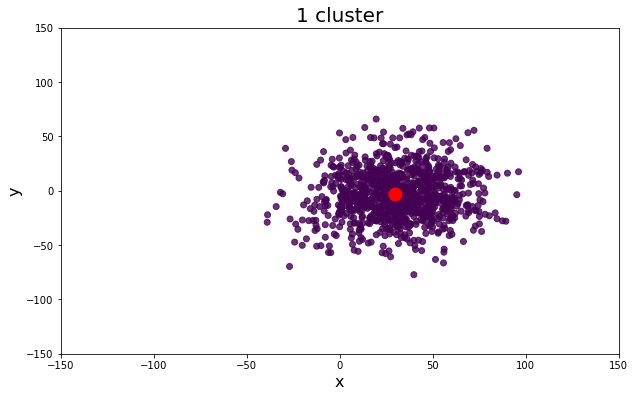

In [1322]:
x = generate_dataset(n_samples=1000, dims=2, centers=1,
                     bounds = (-100.0, 100.0), shuffle=True, return_centers=True)

plt.figure(figsize=(10,6))
plt.title("1 cluster", fontsize=20)
plt.xlim((-150.0, 150.0))
plt.ylim((-150.0, 150.0))
plt.scatter(x[0][:,0], x[0][:,1], c=x[1], alpha=0.8)
plt.scatter(x[2][:, 0], x[2][:, 1], color='red', linewidths=8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

In [1372]:
x = generate_dataset(n_samples=1000, dims=2, centers=2,
                     bounds = (-100.0, 100.0), shuffle=True, return_centers=True, random_state=9)

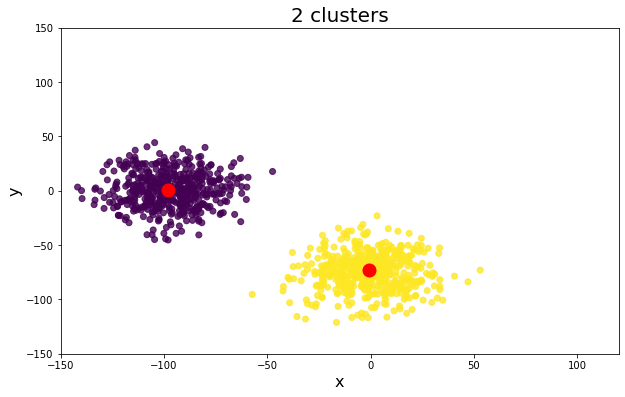

In [1373]:
#red points - centers of clusters (blobs)
plt.figure(figsize=(10,6))
plt.title("2 clusters", fontsize=20)
plt.xlim((-150.0, 120.0))
plt.ylim((-150.0, 150.0))
plt.scatter(x[0][:, 0], x[0][:, 1], c=x[1], alpha=0.8)
plt.scatter(x[2][:, 0], x[2][:, 1], color='red', linewidths=8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

Приведу примеры генерации выборок с заданным числом кластеров

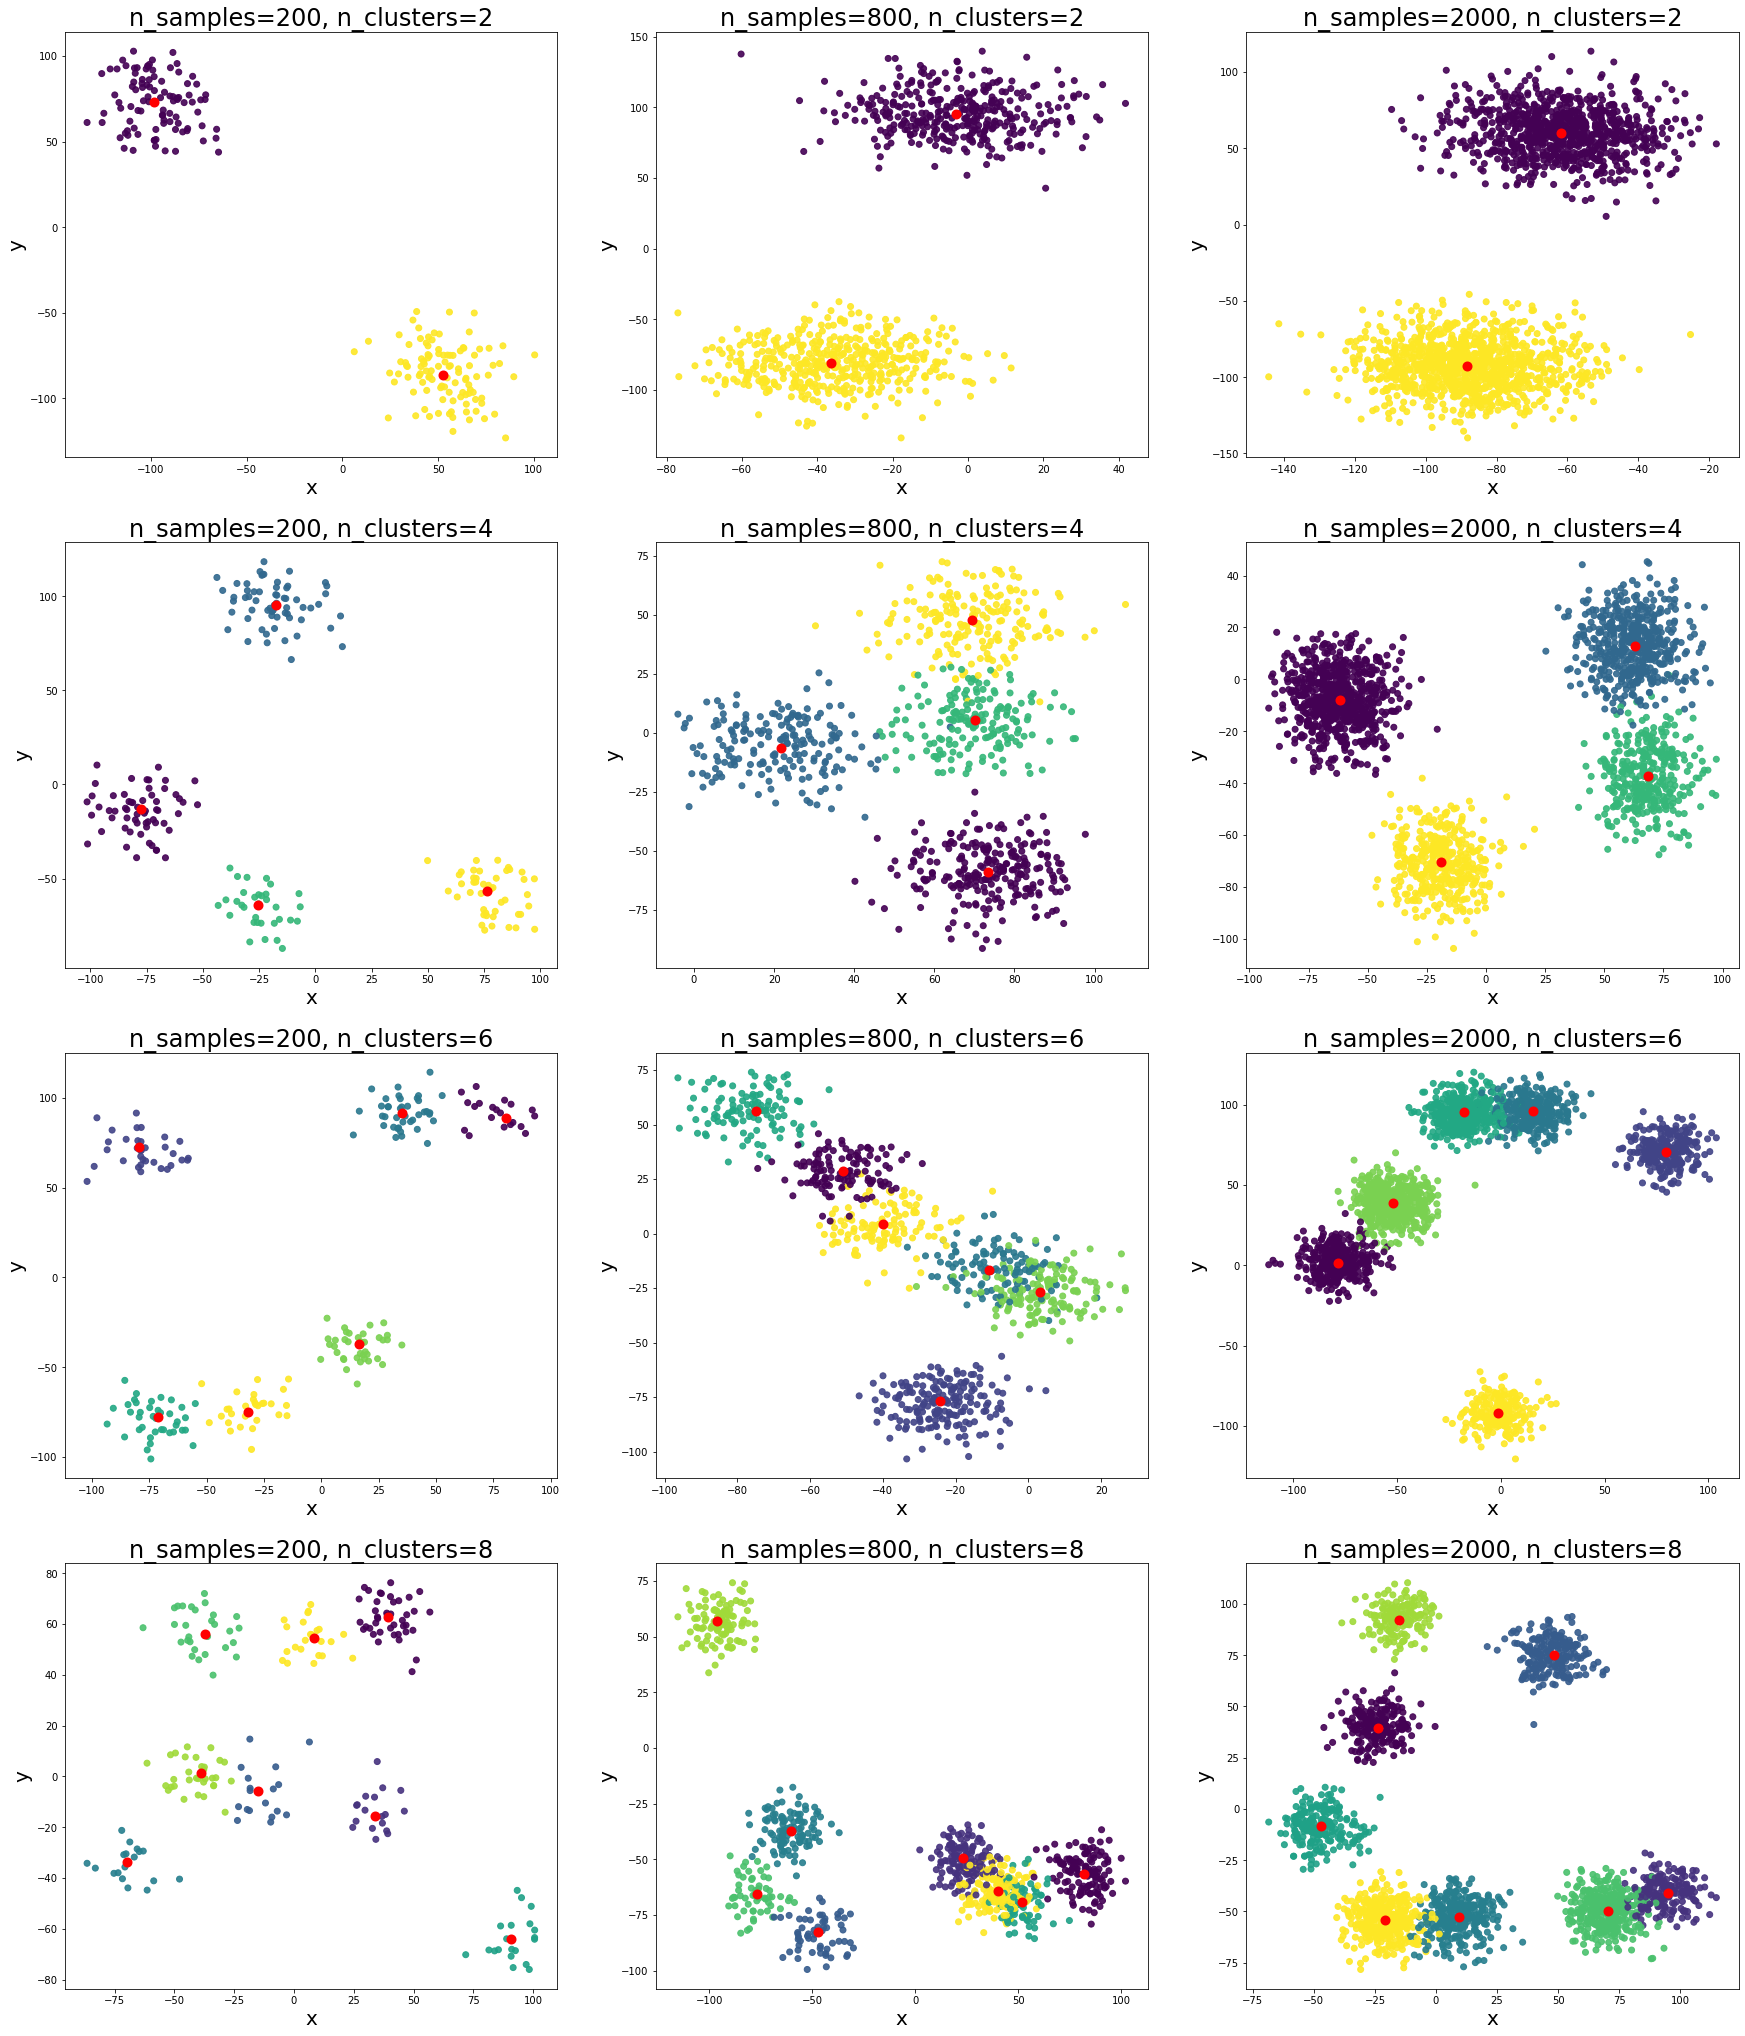

In [1349]:
plt.figure(figsize=(30, 36))
for n_clusters in range (2, 9, 2):
    for i, samples in enumerate([200, 800, 2000]):
        plt.subplot(4, 3, (n_clusters//2 - 1) * 3 + i + 1)
        x = generate_dataset(n_samples=samples, dims=2, centers=n_clusters,
                             bounds = (-100.0, 100.0), shuffle=True, return_centers=True)
        plt.scatter(x[0][:, 0], x[0][:, 1], c=x[1], alpha=0.9)
        plt.scatter(x[2][:, 0], x[2][:, 1], color='red', linewidths=4)
        plt.title(f'n_samples={samples}, n_clusters={n_clusters}', fontsize=24)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)

Пример генерации выборки с заданными заранее центрами кластеров 

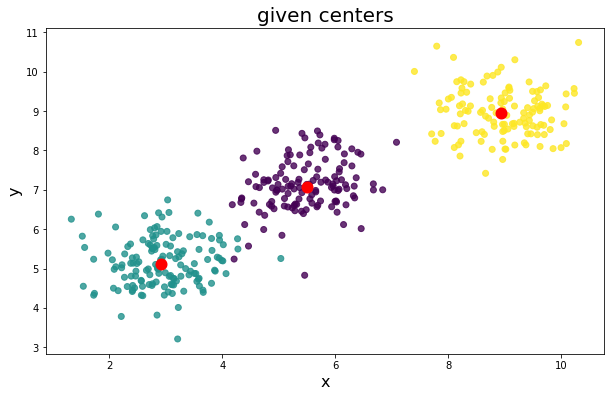

In [1398]:
np.random.seed(3)
clusters = np.random.rand(3, 2) * 10
bounds = (0, 10)
n_samples = 400
x = generate_dataset(n_samples=n_samples, centers=clusters, bounds = bounds, return_centers=True)

plt.figure(figsize=(10,6))
plt.title("given centers", fontsize=20)
plt.scatter(x[0][:, 0], x[0][:, 1], c=x[1], alpha=0.8)
plt.scatter(x[2][:, 0], x[2][:, 1], color='red', linewidths=6)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

Генерация простой выборки без кластеров

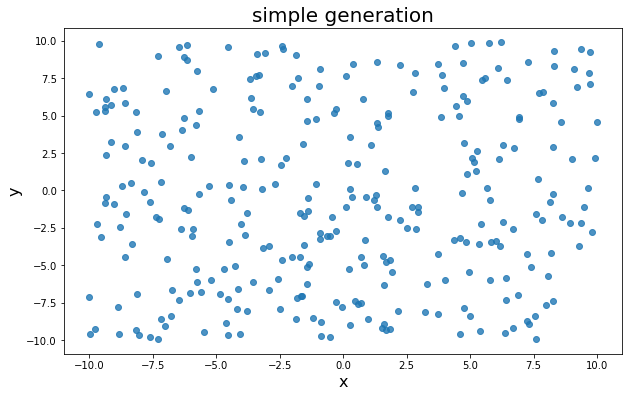

In [1381]:
n_samples = 303
x = generate_dataset(n_samples=n_samples)

plt.figure(figsize=(10,6))
plt.title("simple generation", fontsize=20)
plt.scatter(x[0][:, 0], x[0][:, 1], alpha=0.8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

### Реализация K-Means
C дополнительным ключом KM_plus : K-Means++

На лекции объясняли основной алгоритм K-Means и я реализовал его с оболочкой, подобной KMeans из sklearn: на основe ООП, в документации можно узнать параметры для получения экземпляра класса и функционал fit_predict.

Функции `__gen_centers_plus` и `__gen_centers` приватные методы, генерирующие начальное расположение центров кластеров в случае K-Means++ и KMeans соответственно

In [17]:
from numpy.linalg import norm

In [18]:
class KMeans_custom:
    """
    Realization of K-Means and K-Means++ clustering.
    
    Parameters
    ----------
    n_clusters : int 
        The number of clusters to form as well as the number of centroids to generate. (must be >=1)
    max_iter : int, default=300
        Maximum number of iterations of the k-means algorithm for a single run.
    tol : float, default=1e-4
        Relative tolerance with regards to Frobenius norm of the difference 
        in the cluster centers of two consecutive iterations to declare convergence.
    KM_plus : bool, default=True
        activates K-Means++ method to speed up convergence
    verbose : bool, default=False
        if True: prints steps of iteration and current difference of centers in the last iteration
    random_state: int, default=None
        seed of numpy's pseudo number generation
        if None - seed isn't set
    return_centers : bool, default=False
        return coordinates of centers of clusters
    
    Returns
    -------
    KMeans object
    
    METHODS:
    
    fit_predict - classify given samples with init's parameters of the class instance
    
    Arguments
    ---------
    X : ndarray of shape(n_samples, dims)
        input ndarray with points to classify
    
    Returns
    -------
    Samples : ndarray of shape(n_samples, dims)
        generated samples
    labels : ndarray of shape(n_samples)
        markers for each sample that shows which blob sample belongs to
        doesn't return if "centers" is None
    coord_centers : ndarray of shape(centers, dims)
        The centers of each cluster. Only returnes if "return_centers"=True
        
    """
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, KM_plus=True, 
                 verbose=False, random_state=None, return_centers=False):
        
        if not isinstance(n_clusters, int):
            raise ValueError("'n_clusters' must be int")
        if n_clusters < 1:
            raise ValueError("'n_clusters' must be >= 1")
        self.n_clusters = n_clusters
        
        if not isinstance(max_iter, int):
            raise ValueError("'max_iter' must be int")
        self.max_iter = max_iter
        
        if (not isinstance(tol, float)) and (not isinstance(tol, int)):
            raise ValueError("'tol' must be float")
        self.tol = float(tol)
        
        self.KM_plus = KM_plus
        self.verbose = verbose
        self.return_centers = return_centers
        
        if isinstance(random_state, int):
            self.random_state = random_state
        else:
            self.random_state = None
        
        
    def __gen_centers_plus(self, samples):
        n_centers = self.n_clusters
        if n_centers > len(samples): #n_centers <= len(samples)
            n_centers = len(samples)
        centers = []
        current_center = samples[np.random.randint(len(samples))]
        centers.append(current_center)

        for i in range(n_centers - 1):
            points_mins = []

            for j in range(len(samples)):
                differ_points = [samples[j] - cur_centers for cur_centers in centers]
                distances = norm(np.array(differ_points), axis=1)**2
                d_x2 = distances.min()
                points_mins.append(d_x2)

            points_mins = np.array(points_mins)
            answer = np.argmax(points_mins)
            centers.append(samples[answer])

        return np.array(centers)
    def __gen_centers(self, samples):
        return np.random.permutation(samples)[:self.n_clusters]
    def __centers_dist(self, x, y):
        return norm(x-y)
    def fit_predict(self, samples):
        #centers initialization
        if isinstance(self.random_state, int):
            np.random.seed(self.random_state)
        if self.KM_plus:
            centers = self.__gen_centers_plus(samples)
        else:
            centers = self.__gen_centers(samples)
        self.n_clusters = len(centers)
        labels = np.zeros(len(samples), dtype=np.int64)
        dim = centers.shape[1]
        
        # iterations of KMeans
        for iteration in range(self.max_iter): 
            # assignment
            for i in range(len(samples)):
                samp_to_cent_distance = norm(samples[i] - centers, axis=1)
                labels[i] = np.argmin(samp_to_cent_distance)
            new_centers = np.zeros((self.n_clusters, dim))
            # update
            for j in range(self.n_clusters): 
                cluster_points = samples[labels==j]
                if len(cluster_points) == 0:
                    new_centers[j] = centers[j]
                else:
                    new_centers[j] = (cluster_points.sum(axis=0))/len(cluster_points)
            current_difference = self.__centers_dist(new_centers, centers)
            if self.verbose:
                print(f"iteration: {iteration}; difference: {current_difference}")
            if current_difference <= self.tol:
                break
            centers = new_centers #old centers will be deleted (garbage collector)
        if self.return_centers:
            return samples, labels, new_centers
        return samples, labels

### Проверка

Проверим реализацию на адекватность вывода (алгоритм должен хорошо разделять кластеры между собой)

Сгенерируем выборку с 4-мя кластерами из 4000 элементов созданной ранее функцией

In [199]:
%%time

dataset = generate_dataset(n_samples=4000, centers=4, random_state=10)

CPU times: user 7.98 ms, sys: 340 µs, total: 8.32 ms
Wall time: 6 ms


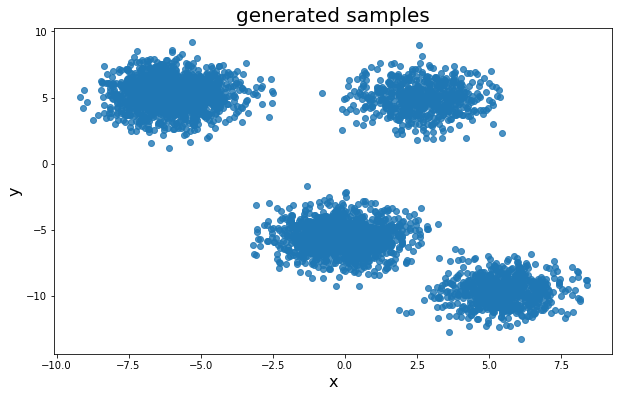

In [200]:
plt.figure(figsize=(10,6))
plt.title("generated samples", fontsize=20)
plt.scatter(dataset[0][:, 0], dataset[0][:, 1], alpha=0.8)
# plt.scatter(dataset[2][:, 0], dataset[2][:, 1], color='red', linewidths=6) #print centers
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

K-Means++

In [208]:
%%time

result = KMeans_custom(n_clusters=4, KM_plus=True, random_state=12, return_centers=True).fit_predict(dataset[0])

CPU times: user 328 ms, sys: 4.66 ms, total: 332 ms
Wall time: 306 ms


Красные точки - найденные центры кластеров

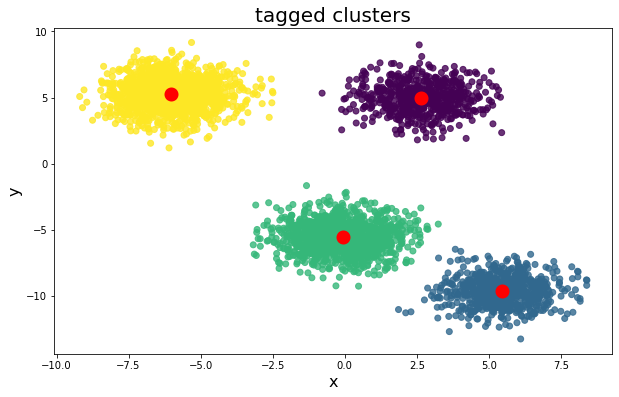

In [209]:
plt.figure(figsize=(10,6))
plt.title("tagged clusters", fontsize=20)
plt.scatter(result[0][:, 0], result[0][:, 1], c=result[1], alpha=0.8)
plt.scatter(result[2][:, 0], result[2][:, 1], color='red', linewidths=8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

K-Means

In [210]:
%%time

result = KMeans_custom(n_clusters=4, KM_plus=False, random_state=12, return_centers=True).fit_predict(dataset[0])

CPU times: user 248 ms, sys: 7.92 ms, total: 256 ms
Wall time: 245 ms


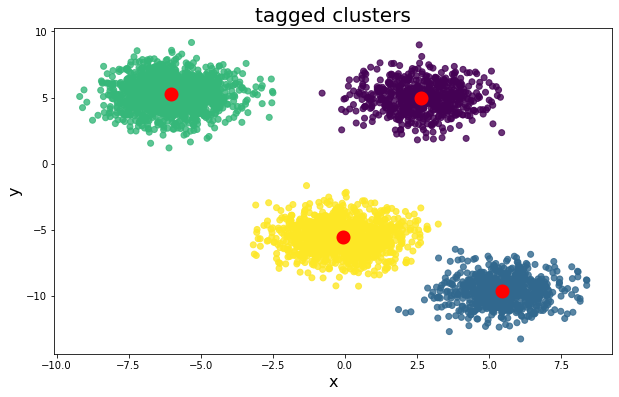

In [211]:
plt.figure(figsize=(10,6))
plt.title("tagged clusters", fontsize=20)
plt.scatter(result[0][:, 0], result[0][:, 1], c=result[1], alpha=0.8)
plt.scatter(result[2][:, 0], result[2][:, 1], color='red', linewidths=8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

Сравнивая время выполнения, можно заметить, что метод K-Means работает лучше K-Means++ на некоторых выборках. Но так происходит не всегда (возьмём в KMeans seed=11)

In [212]:
%%time

result = KMeans_custom(n_clusters=4, KM_plus=False, random_state=11, return_centers=True).fit_predict(dataset[0])

CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.48 s


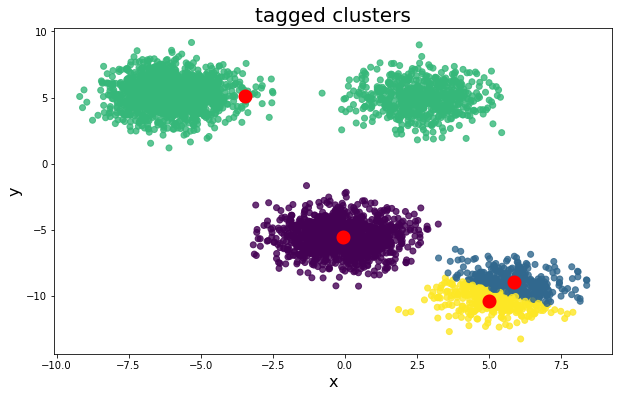

In [213]:
plt.figure(figsize=(10,6))
plt.title("tagged clusters", fontsize=20)
plt.scatter(result[0][:, 0], result[0][:, 1], c=result[1], alpha=0.8)
plt.scatter(result[2][:, 0], result[2][:, 1], color='red', linewidths=8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

Заметим, что результат заметно ухудшился, однако K-Means++ будет работать всё так же хорошо на разных seed (много plot'ов в ноутбук не влезет - поэтому не вывожу все тесты)

In [214]:
%%time
for i in range(10, 20):
    result = KMeans_custom(n_clusters=4, KM_plus=False,
                           random_state=i, return_centers=True).fit_predict(dataset[0])

CPU times: user 3.54 s, sys: 2.93 ms, total: 3.54 s
Wall time: 3.5 s


Всего было 10 тестов, следовательно в среднем на одно предсказание уходило $3.5/10 = 0.35$ секунд (выборка из 4000 элементов), это заментно быстрее $1.5$ секунды в обычном K-Means

### Сравнение KMeans_custom и KMeans из sklearn

In [227]:
from sklearn.cluster import KMeans

In [228]:
%%time

dataset = generate_dataset(n_samples=2000, centers=3, random_state=3)

CPU times: user 2.64 ms, sys: 4.43 ms, total: 7.07 ms
Wall time: 4.36 ms


Для начала сравним время работы в режиме обычного KMeans

In [349]:
%%time

result1 = KMeans_custom(n_clusters=3, KM_plus=False, random_state=11).fit_predict(dataset[0])

CPU times: user 247 ms, sys: 444 µs, total: 248 ms
Wall time: 237 ms


In [356]:
%%time

result2 = KMeans(n_clusters=3, init='random', random_state=11).fit_predict(dataset[0])

CPU times: user 1.01 s, sys: 54.7 ms, total: 1.07 s
Wall time: 203 ms


Если сравнивать графы `total`: то выходит что моя реализация получилась ***быстрее*** оригинальной, но я не знаю насколько корректно сравнивать именно эти графы

***Время сравнимо***, в оригинальной реализации обычного K-Means `Wall time` в среднем чуть меньше чем в моей реализации, на некоторых тестах она уступает в скорости, но я думаю всё дело в случайности генерируемых чисел


Выведем графики:

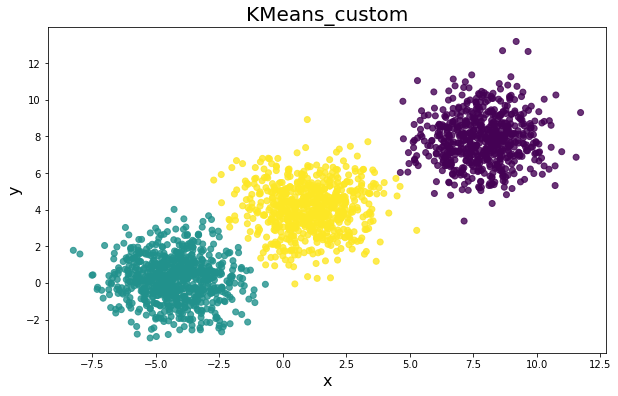

In [346]:
plt.figure(figsize=(10,6))
plt.title("KMeans_custom", fontsize=20)
plt.scatter(result1[0][:, 0], result1[0][:, 1], c=result1[1], alpha=0.8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

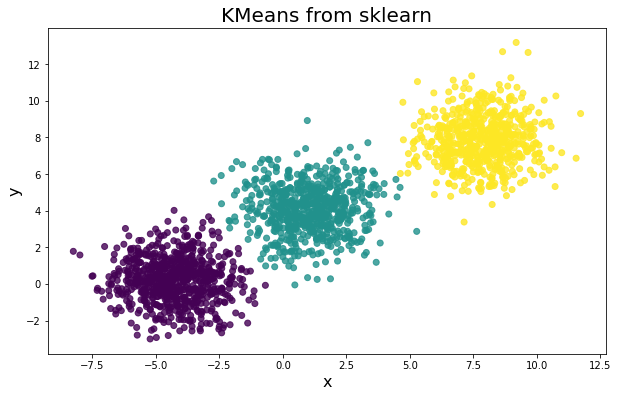

In [347]:
plt.figure(figsize=(10,6))
plt.title("KMeans from sklearn", fontsize=20)
plt.scatter(dataset[0][:, 0], dataset[0][:, 1], c=result2, alpha=0.8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

Теперь сравним методы ***KMeans++***

In [367]:
%%time

dataset = generate_dataset(n_samples=2000, centers=4, random_state=4)

CPU times: user 7.92 ms, sys: 0 ns, total: 7.92 ms
Wall time: 5.06 ms


In [386]:
%%time

result1 = KMeans_custom(n_clusters=3, KM_plus=True, random_state=11).fit_predict(dataset[0])

CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 111 ms


In [387]:
%%time

result2 = KMeans(n_clusters=3, init='k-means++', random_state=11).fit_predict(dataset[0])

CPU times: user 354 ms, sys: 18 ms, total: 372 ms
Wall time: 73.7 ms


Здесь аналогичная ситуация, по графе `total` моя реализация оказывается ***быстрее***, по графе `Wall time` - ***сравнимо***

Графики:

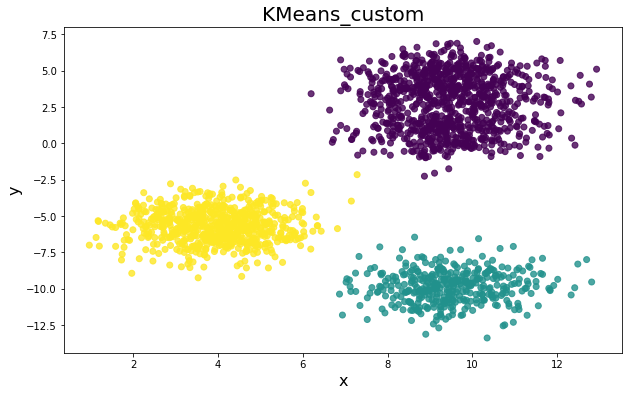

In [390]:
plt.figure(figsize=(10,6))
plt.title("KMeans_custom", fontsize=20)
plt.scatter(result1[0][:, 0], result1[0][:, 1], c=result1[1], alpha=0.8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

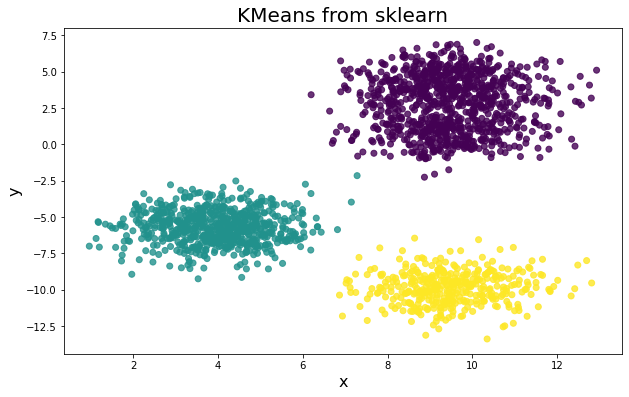

In [391]:
plt.figure(figsize=(10,6))
plt.title("KMeans from sklearn", fontsize=20)
plt.scatter(dataset[0][:, 0], dataset[0][:, 1], c=result2, alpha=0.8)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

### Для каких задач подходит / не подходит

***Подходит***

K-Means очень хорошо решает задачу кластеризации, которая относится к классу задач обучения без учителя.

Обучение без учителя - сложнее, чем обучение с учетелем(с обучающей выборкой), в силу того, что алгоритм не знает ни одного правильного ответа, от которого можно оттолкнуться, а учится сам

Поэтому такой алгоритм может быть очень хорош в задачах, где обучающей выборки нет или её мало

Например, он может использоваться как своеобразный фильтр в задаче распознования изображений(как ядро свёртки) - он может распознать более освещённые участки кусочков изображения

Алгоритм очень хорошо применяется для кластеризации, например: 
1. Выделение групп людей на основе графа связей в социальных сетях
2. Подбор рекомендаций для пользователя на основе предпочтений других пользователей в данном кластере
3. автоматически определять генотипы по различным частям хромосом;
и. т. д.

***Не подходит***

Кластеризация некластеризованных данных - алгоритм будет кластеризовывать однородные данные

Если один кластер довольно большой и разбросанный, а другой маленький и довольно сгруппированный - метод будет плохо работать и неправильно кластеризует точки

Нельзя однозначно сказать, сколько будет кластеров у данных

Алгоритм не может выбраться из локальных минимумов (т е при вычислении центров кластеров, они могут попасть в своеобразную воронку - впадина с локальным минимумом, из которого центр уже не выберется)

### Исследовать зависимость от объёма данных / сложности задачи

In [21]:
for n in [100, 400, 1000, 5000, 10000]:
    for dims in [2, 3, 10]:
        for centers in [None, 1, 3, 6, 20]:
            print(f"-----\tn = {n}; dims = {dims}; centers = {centers}\t-----")
            dataset1 = generate_dataset(n, dims=dims, centers=centers, return_centers=True)
            if centers == None:
                cur_centers = np.random.randint(10) + 1
            else:
                cur_centers = centers
            %time KMeans_custom(n_clusters=cur_centers).fit_predict(dataset1[0])

-----	n = 100; dims = 2; centers = None	-----
CPU times: user 15.5 ms, sys: 4 µs, total: 15.5 ms
Wall time: 15.3 ms
-----	n = 100; dims = 2; centers = 1	-----
CPU times: user 452 µs, sys: 4 ms, total: 4.45 ms
Wall time: 3.83 ms
-----	n = 100; dims = 2; centers = 3	-----
CPU times: user 5.92 ms, sys: 0 ns, total: 5.92 ms
Wall time: 5.93 ms
-----	n = 100; dims = 2; centers = 6	-----
CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 10.1 ms
-----	n = 100; dims = 2; centers = 20	-----
CPU times: user 38.4 ms, sys: 1 µs, total: 38.4 ms
Wall time: 38.4 ms
-----	n = 100; dims = 3; centers = None	-----
CPU times: user 6.9 ms, sys: 0 ns, total: 6.9 ms
Wall time: 6.9 ms
-----	n = 100; dims = 3; centers = 1	-----
CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 1.68 ms
-----	n = 100; dims = 3; centers = 3	-----
CPU times: user 5.64 ms, sys: 0 ns, total: 5.64 ms
Wall time: 5.64 ms
-----	n = 100; dims = 3; centers = 6	-----
CPU times: user 13.1 ms, sys: 3 µs, total: 13.1 ms

CPU times: user 708 ms, sys: 44.2 ms, total: 753 ms
Wall time: 679 ms
-----	n = 10000; dims = 10; centers = 6	-----
CPU times: user 2.42 s, sys: 28.1 ms, total: 2.45 s
Wall time: 2.4 s
-----	n = 10000; dims = 10; centers = 20	-----
CPU times: user 3.97 s, sys: 44.1 ms, total: 4.01 s
Wall time: 3.96 s


Исходя из проведённого опыта с замером времени работы, можно заметить, что параметр dims практически не изменяет время работы, а параметры centers и n_samples(n) увеличивают время работы линейно, т е time complexity = $O(N*t)$, где $N =$ n_samples, $t =$ centers 

### Выбор числа кластеров

Если рассмотреть сумму квадратов расстояний всех точек до их ближайших (сгенерированных) центров, вывести эти суммы для различных k - число кластеров, которые идут на вход K-Means, то график этих сумм будет резко убывать до достижения аргументом k некоторого значения k* а затем уже не так быстро убывать - таким способом можно найти наболее подходящее число кластеров для данных

In [43]:
def comput_sum(samples, labels, centers):
    s = 0
    for i in range(len(centers)):
        difference = samples[labels == i] - centers[i]
        norm_diff = norm(difference, axis=1)**2
        s += norm_diff.sum()
    return s

In [48]:
dataset1 = generate_dataset(5000, dims=2, centers=5, return_centers=True)
custom_sum_k = []
for k in range(1, 11):
    instance_curr = KMeans_custom(n_clusters=k, return_centers=True).fit_predict(dataset1[0])
    custom_sum_k.append(comput_sum(*instance_curr))

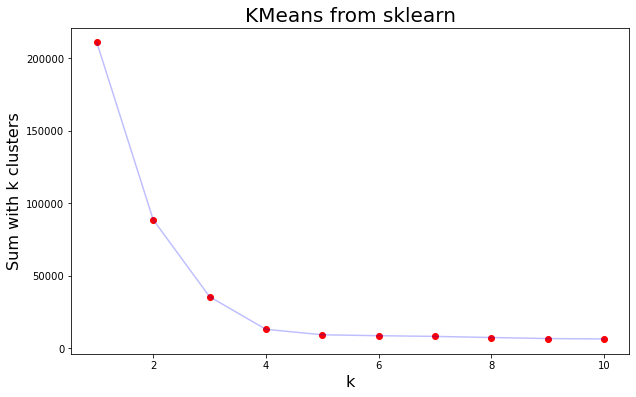

In [62]:
plt.figure(figsize=(10,6))
plt.title("KMeans from sklearn", fontsize=20)
plt.scatter(list(range(1,11)), custom_sum_k, color='red')
plt.plot(list(range(1,11)), custom_sum_k, alpha=0.25, color='blue')
plt.xlabel("k", fontsize=16)
plt.ylabel("Sum with k clusters", fontsize=16)
plt.show()

Как можно заметить резкий спад заканчивается примерно при $k=5$, а значит скорее всего и выборка было с 5-ю кластерами

### Визуализация матрицы попарных расстояний

Для хорошей визуализации нужно отсортировать samples по labels

In [164]:
dataset1 = generate_dataset(50, dims=2, centers=5, return_centers=True, random_state=2)

In [165]:
def matrix_make(samples, labels, sort_it): 
    result = np.zeros((len(samples), len(samples)))
    
    curr_list = np.append(samples, labels[:, np.newaxis], axis=1)
    if sort_it:
        curr_list = np.array(sorted(curr_list, key=lambda x: x[2]))
    
    for i in range(len(samples)):
        for j in range(len(samples)):
            result[j, i] = result[i, j] = (norm(curr_list[i,:(curr_list.shape[1] - 1)] - curr_list[j, :(curr_list.shape[1] - 1)]))
    return result

In [166]:
#marked samples
marked_samples = KMeans_custom(n_clusters=4, random_state=2).fit_predict(dataset1[0])

Матрица попарных расстояний ***до*** сортировки

In [167]:
x = matrix_make(marked_samples[0], marked_samples[1], False)

<Figure size 864x576 with 0 Axes>

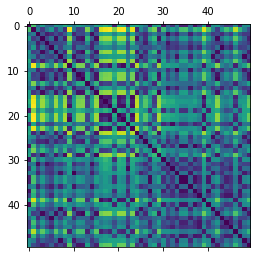

In [168]:
plt.figure(figsize=(12, 8))
plt.matshow(x)
plt.show()

Матрица попарных расстояний ***после*** сортировки

In [169]:
y = matrix_make(marked_samples[0], marked_samples[1], True)

<Figure size 864x576 with 0 Axes>

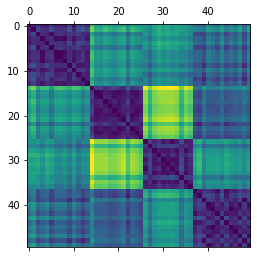

In [170]:
plt.figure(figsize=(12, 8))
plt.matshow(y)
plt.show()

Тут уже хорошо видны кластеры